In [1]:
# Dataframe, Numbers, Stats
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import itertools

# Visualization
import pydotplus, graphviz
import matplotlib.pyplot as plt
import seaborn as sns
from keplergl import KeplerGl
from IPython.display import Image

# ML Models
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Audio Analysis
import librosa, IPython
import librosa.display 

# Graph Settings
sns.set_style('dark')
plt.style.use('dark_background')


## 1. Data Description

The data I will be using comes from the Free Music Archive (FMA) https://github.com/mdeff/fma. The FMA is a selection of information for 100K+ audio tracks (as well as the audio files themselves) that are licensed under Creative Commons for the express purpose of machine learning research.

Along with the audio files, there are multiple data sets, but we will be using two:
* tracks.csv: per track metadata such as ID, title, artist, genres, tags and play counts, for all 106,574 tracks.
* features.csv: common features extracted with librosa.

The combination of these two will form the basis of our machine learning features.

## 2. EDA

In [2]:
# View preference for large db
pd.set_option('precision', 2, 'max_columns', None)

In [3]:
# Tracks contains the metadata of all the music files. Certain columns chosen.
tracks = pd.read_csv('/Users/DanCassin/Development/python/Notebooks/Thinkful/Supervised_Learning_Data/fma_metadata/tracks.csv',
                    low_memory=False, skiprows=[0,2], index_col=0,
                    usecols=[0,2,3,22,23,24,26,32,38,40,52], parse_dates=['date_created', 'date_released']
                    )
tracks.info()
tracks.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date_created   103045 non-null  datetime64[ns]
 1   date_released  70294 non-null   datetime64[ns]
 2   latitude       44544 non-null   float64       
 3   location       70210 non-null   object        
 4   longitude      44544 non-null   float64       
 5   name           106574 non-null  object        
 6   subset         106574 non-null  object        
 7   duration       106574 non-null  int64         
 8   genre_top      49598 non-null   object        
 9   title.1        106573 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 8.9+ MB


,date_created,date_released,latitude,location,longitude,name,subset,duration,genre_top,title.1
2,2008-11-26 01:44:45,2009-01-05,40.06,New Jersey,-74.41,AWOL,small,168,Hip-Hop,Food
3,2008-11-26 01:44:45,2009-01-05,40.06,New Jersey,-74.41,AWOL,medium,237,Hip-Hop,Electric Ave
5,2008-11-26 01:44:45,2009-01-05,40.06,New Jersey,-74.41,AWOL,small,206,Hip-Hop,This World
10,2008-11-26 01:45:08,2008-02-06,NaN,NaN,NaN,Kurt Vile,small,161,Pop,Freeway
20,2008-11-26 01:45:05,2009-01-06,51.90,Colchester England,0.89,Nicky Cook,large,311,NaN,Spiritual Level


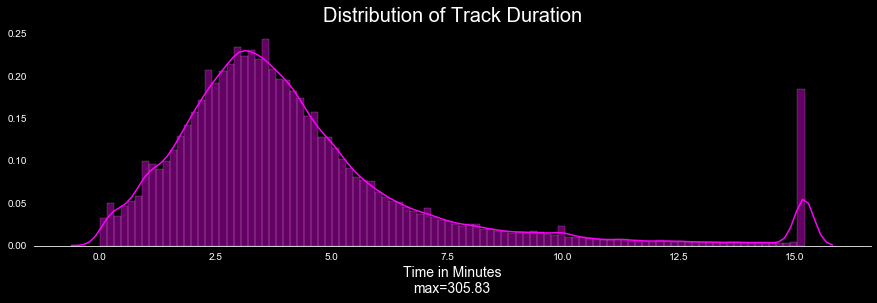

In [4]:
fig, ax = plt.subplots(figsize=(15,4))
ax = sns.distplot(winsorize(tracks['duration']/60, (0,0.0275)), color='magenta', bins=100, hist_kws={'linewidth':0.4})
ax.set_title('Distribution of Track Duration', fontsize=20)
ax.set_xlabel(f'Time in Minutes\nmax={tracks.duration.max()/60:.2f}', fontsize=14)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

In [5]:
# Data above was winsorized on the high end for ease of visualizing
# Interested in the numeber of very long songs at the far right
long_songs = tracks[tracks['duration']>900]
# Removing the songs with no genre
long_songs = long_songs.dropna(axis=0, subset=['genre_top'])

long_songs.sort_values('duration', ascending=False)[:20]
# Unsurprisingly they are mostly instrumental and experimental. Will keep the data non-winsorized
# as it may aid in genre prediction

,date_created,date_released,latitude,location,longitude,name,subset,duration,genre_top,title.1
122567,2015-07-14 20:54:47,NaT,NaN,New England,NaN,P C III,large,11030,Instrumental,In the Garden
39522,2010-11-22 22:18:20,NaT,34.05,Los Angeles,-118.24,Really Happening,large,3718,Experimental,MCRH LA 10 11 20 Really solo Part 2
43100,NaT,NaT,-41.29,"Wellington, New Zealand",174.78,The Tudor Consort,large,3716,Classical,Passio Domini Nostri Jesu Christe
9702,2009-04-03 01:24:23,2005-12-17,52.13,The Netherlands,5.29,Nynack,large,3714,Electronic,Nynack Live at TodaysArt Festival
112067,2014-12-06 19:07:02,NaT,NaN,New England,NaN,P C III,large,3714,Electronic,To Our Yes
46752,2011-04-13 13:21:09,NaT,NaN,NaN,NaN,Eliane Radigue,large,3713,Experimental,NWREI Radigue
1564,2008-11-26 03:02:48,2009-01-22,39.29,"Baltimore, MD",-76.61,Sejayno,large,3710,Experimental,Reverse Time Apex side 2
107797,2014-07-31 23:40:23,2014-08-01,NaN,NaN,NaN,Mutant Beatniks,large,3706,Spoken,MONO
153890,2016-01-23 10:07:07,NaT,NaN,NaN,NaN,Ram Gabay,large,3703,Experimental,improv@halas.am
11762,2009-04-30 14:11:22,2007-03-10,37.77,"San Francisco, CA",-122.42,Negativland,large,3701,Experimental,It's All in Your Head (Part 2)


In [6]:
# Getting number of tracks per year for xticks
years = list(tracks['date_created'].dt.year.unique())
del years[2]
for i in range(len(years)):
    years[i] = int(years[i])
years

[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2016, 2015, 2017]

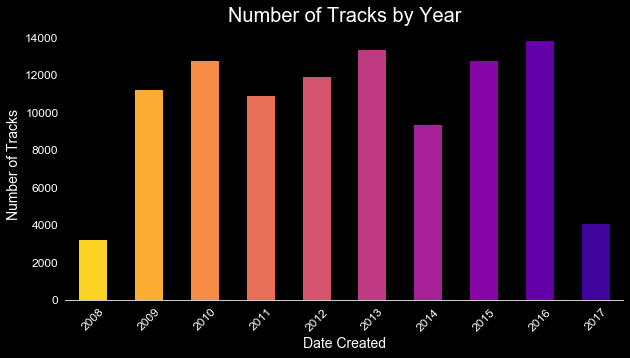

In [7]:
# Plotting
tracks_by_year = tracks[['date_created','title.1']].groupby(tracks['date_created'].dt.year).count()

fig,ax = plt.subplots(figsize=(10,5))
tracks_by_year.plot(kind='bar', y='title.1', color=sns.color_palette('plasma_r', len(years)), 
                    linewidth=0, ax=ax)
ax.set_title('Number of Tracks by Year', fontsize=20)
plt.xticks(range(10),labels=sorted(years), rotation=45, fontsize=12, )
plt.yticks(fontsize=12)
ax.set_xlabel('Date Created', fontsize=14)
ax.set_ylabel('Number of Tracks', fontsize=14)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend().set_visible(False);
# Most of the data is between 2009 and 2016

In [9]:
# Mapping the geographic location of the artists via KeplerGL
config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'qrulzi',
     'type': 'point',
     'config': {'dataId': 'Artist_Locations',
      'label': 'Location',
      'color': [30, 150, 190],
      'columns': {'lat': 'latitude', 'lng': 'longitude', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 0.19,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Uber Viz Qualitative 3',
        'type': 'qualitative',
        'category': 'Uber',
        'colors': ['#12939A',
         '#DDB27C',
         '#88572C',
         '#FF991F',
         '#F15C17',
         '#223F9A',
         '#DA70BF',
         '#125C77',
         '#4DC19C',
         '#776E57',
         '#17B8BE',
         '#F6D18A',
         '#B7885E',
         '#FFCB99',
         '#F89570']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'genre_top', 'type': 'string'},
      'colorScale': 'ordinal',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'Artist_Locations': ['date_released',
       'location',
       'name',
       'genre_top',
        'title.1']},
     'enabled': True},
    'brush': {'size': 23.5, 'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 19.56981491943249,
   'longitude': 10.511586077423015,
   'pitch': 0,
   'zoom': 0.7143720653520246,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

#Create a basemap 
map = KeplerGl(height=400, width=1400, config=config)
map.add_data(data=tracks.dropna().drop(['date_created','date_released'], axis=1), name='Artist_Locations')

map.save_to_html( config=config, file_name='first_map.html')

map
# This is a very international selection with most of the data coming from the US and Europe
# More Rock (light brown) coming from the US and more Electronic (orange) coming from Europe... unsurprising

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
Map saved to first_map.html!


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'qrulzi', 'type': '…

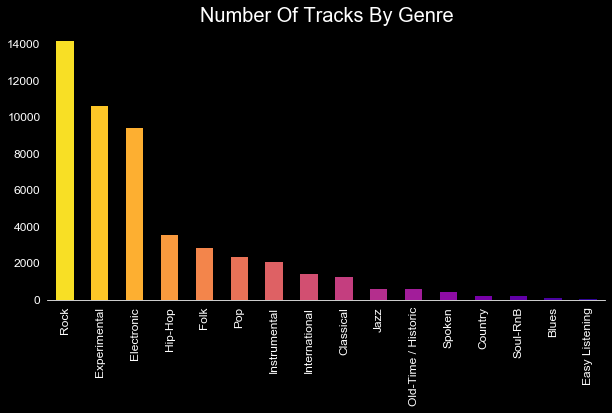

In [10]:
# Seeing the counts of all genres
genre_counts = tracks['genre_top'].dropna().value_counts()

# Plotting
fig,ax = plt.subplots(figsize=(10,5))
genre_counts.plot(kind='bar', color=sns.color_palette('plasma_r', len(genre_counts)), linewidth=0)
ax.set_title('Number Of Tracks By Genre', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True);
# Data is biased towards rock, experimental and electronic

In [11]:
# Introducing the second dataframe
# Features Database was extracted via the Librosa library
features = pd.read_csv('/Users/DanCassin/Development/python/Notebooks/Thinkful/Supervised_Learning_Data/fma_metadata/features.csv',
                low_memory=False, index_col=0, header=[0, 1, 2])

features.info()
features.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Columns: 518 entries, ('chroma_cens', 'kurtosis', '01') to ('zcr', 'std', '01')
dtypes: float64(518)
memory usage: 422.0 MB


feature    chroma_cens                                                        \
statistics    kurtosis                                                         
number              01    02    03    04    05    06    07    08    09    10   
track_id                                                                       
2                 7.18  5.23  0.25  1.35  1.48  0.53  1.48  2.69  0.87  1.34   
3                 1.89  0.76  0.35  2.30  1.65  0.07  1.37  1.05  0.11  0.62   
5                 0.53 -0.08 -0.28  0.69  1.94  0.88 -0.92 -0.93  0.67  1.04   
10                3.70 -0.29  2.20 -0.23  1.37  1.00  1.77  1.60  0.52  1.98   
20               -0.19 -0.20  0.20  0.26  0.78  0.08 -0.29 -0.82  0.04 -0.80   

feature                                                                       \
statistics               max                                                   
number        11    12    01    02    03    04    05    06    07    08    09   
track_id                                                                       
2           1.35  1.24  0.69  0.57  0.60  0.63  0.57  0.44  0.49  0.50  0.57   
3           1.04  1.29  0.68  0.58  0.58  0.58  0.45  0.46  0.54  0.66  0.51   
5           0.27  1.13  0.61  0.65  0.49  0.45  0.47  0.45  0.50  0.56  0.67   
10          4.33  1.30  0.46  0.54  0.45  0.65  0.59  0.51  0.65  0.52  0.51   
20         -0.99 -0.43  0.65  0.68  0.67  0.60  0.65  0.70  0.66  0.69  0.64   

feature                                                                       \
statistics                    mean                                             
number        10    11    12    01    02    03    04    05    06    07    08   
track_id                                                                       
2           0.58  0.62  0.59  0.47  0.37  0.24  0.23  0.22  0.22  0.23  0.25   
3           0.53  0.60  0.55  0.23  0.23  0.23  0.22  0.22  0.24  0.37  0.42   
5           0.61  0.55  0.60  0.26  0.30  0.25  0.22  0.25  0.24  0.28  0.29   
10          0.48  0.64  0.64  0.23  0.29  0.24  0.23  0.19  0.29  0.41  0.35   
20          0.67  0.69  0.68  0.20  0.25  0.26  0.19  0.18  0.24  0.28  0.29   

feature                                                                        \
statistics                         median                                       
number        09    10    11    12     01    02    03    04    05    06    07   
track_id                                                                        
2           0.20  0.18  0.20  0.32   0.48  0.39  0.25  0.24  0.23  0.23  0.23   
3           0.31  0.24  0.26  0.23   0.23  0.23  0.21  0.20  0.23  0.26  0.39   
5           0.35  0.29  0.25  0.22   0.26  0.29  0.25  0.22  0.25  0.24  0.28   
10          0.27  0.24  0.27  0.24   0.23  0.28  0.23  0.23  0.21  0.28  0.44   
20          0.25  0.29  0.30  0.24   0.20  0.22  0.23  0.19  0.16  0.24  0.26   

feature                                                                       \
statistics                                     min                             
number        08    09    10    11    12        01        02    03   04   05   
track_id                                                                       
2           0.25  0.20  0.17  0.20  0.31  0.00e+00  0.00e+00  0.00  0.0  0.0   
3           0.44  0.31  0.24  0.26  0.23  0.00e+00  0.00e+00  0.00  0.0  0.0   
5           0.29  0.35  0.28  0.24  0.21  0.00e+00  0.00e+00  0.00  0.0  0.0   
10          0.36  0.27  0.24  0.25  0.23  3.35e-04  2.52e-03  0.01  0.0  0.0   
20          0.27  0.24  0.27  0.29  0.24  0.00e+00  0.00e+00  0.00  0.0  0.0   

feature                                                                       \
statistics                                                    skew             
number       06        07        08   09   10        11   12    01        02   
track_id                                                                       
2           0.0  0.00e+00  0.00e+00  0.0  0.0  0.00e+00  0.0 -2.00

features.csv contains information on 106,574 audio files. The 518 features were derived via processes in the library Librosa. All of this data is mathmatical analysis of the audio data.

In [12]:
# Locating an audio track to analyze
tracks.loc[9555]

date_created     2009-04-02 14:37:14
date_released    2009-04-02 00:00:00
latitude                         NaN
location                         NaN
longitude                        NaN
name                   Kristin Hersh
subset                         small
duration                         334
genre_top                       Rock
title.1                        Krait
Name: 9555, dtype: object

In [13]:
# Loading the audio file via Librosa
y, sr = librosa.load('/Users/DanCassin/Development/python/Notebooks/Thinkful/Supervised_Learning_Data/fma_small/009/009555.mp3')

# Loading audio player
IPython.display.Audio(data=y, rate=sr)

/Users/DanCassin/Development/python/python/lib/python3.8/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [14]:
# Determing estimated tempo as an example of data Librosa can extrapolate
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

#beat_times = librosa.frames_to_time(beat_frames, sr=sr)

Estimated tempo: 143.55 beats per minute


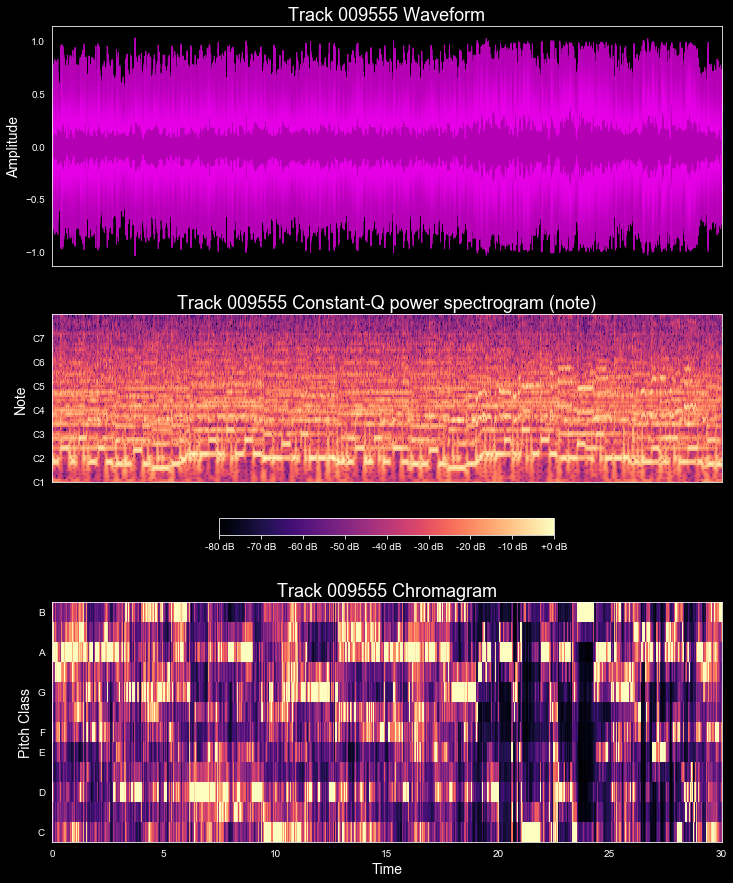

In [15]:
# Plotting different audio visualizations from Librosa
fig,ax = plt.subplots(figsize=(12, 15))

ax1 = plt.subplot(3,1,1)
librosa.display.waveplot(y, sr=sr,alpha=.7, color='magenta')
ax1.set_title('Track 009555 Waveform', fontsize=18)
ax1.set_ylabel('Amplitude', fontsize=14)
ax1.set_xlabel('')

ax2 = plt.subplot(3,1,2)
CQT = librosa.amplitude_to_db(np.abs(librosa.cqt(y, sr=sr)), ref=np.max)
librosa.display.specshow(CQT, y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB', orientation='horizontal', shrink=.5)

ax2.set_title('Track 009555 Constant-Q power spectrogram (note)',fontsize=18)
ax2.set_ylabel('Note', fontsize=14)
ax2.set_xlabel('')

ax3 = plt.subplot(3,1,3)
S = np.abs(librosa.stft(y))**2
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
#plt.colorbar(orientation='horizontal', shrink=.5)
ax3.set_title('Track 009555 Chromagram', fontsize=18)
ax3.set_ylabel('Pitch Class', fontsize=14)
ax3.set_xlabel('Time', fontsize=14);

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

In [16]:
# These features from Librosa are what make up features.csv
# and this data is  what we will base our model on
print(f'Feature - Chroma: \n{librosa.feature.chroma_stft(y=y, sr=sr)[0][:12]}')
print(f'Feature - MFCC: \n{librosa.feature.mfcc(y=y, sr=sr)[0][:12]}')
print(f'Feature - Tonal Centroid: \n{librosa.feature.tonnetz(y=y, sr=sr)[0][:12]}')

Feature - Chroma: 
[0.22604746 0.2813215  0.43854785 0.38476217 0.29997423 0.22585545
 0.3071451  0.49568754 0.5070596  0.3791621  0.4562435  0.62668973]
Feature - MFCC: 
[-173.72845    -62.192673   -22.59986    -21.357674   -26.206614
  -35.734097   -37.670322   -21.697405   -10.4489765  -10.636153
  -14.840432   -22.281391 ]
Feature - Tonal Centroid: 
[-0.06236429 -0.02302188 -0.00348127  0.00058128 -0.00780228 -0.02043068
 -0.01287018 -0.02469406 -0.04650844 -0.02041531 -0.01071213 -0.01129399]


## 3. Feature Selection

In [17]:
# Here we will be merging the interesting columns from tracks.csv with features.csv
merged = pd.merge(features, tracks[['duration','genre_top']], left_index=True, right_index=True)

merged.head()

/Users/DanCassin/Development/python/python/lib/python3.8/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)","(chroma_cens, kurtosis, 11)","(chroma_cens, kurtosis, 12)","(chroma_cens, max, 01)","(chroma_cens, max, 02)","(chroma_cens, max, 03)","(chroma_cens, max, 04)","(chroma_cens, max, 05)","(chroma_cens, max, 06)","(chroma_cens, max, 07)","(chroma_cens, max, 08)","(chroma_cens, max, 09)","(chroma_cens, max, 10)","(chroma_cens, max, 11)","(chroma_cens, max, 12)","(chroma_cens, mean, 01)","(chroma_cens, mean, 02)","(chroma_cens, mean, 03)","(chroma_cens, mean, 04)","(chroma_cens, mean, 05)","(chroma_cens, mean, 06)","(chroma_cens, mean, 07)","(chroma_cens, mean, 08)","(chroma_cens, mean, 09)","(chroma_cens, mean, 10)","(chroma_cens, mean, 11)","(chroma_cens, mean, 12)","(chroma_cens, median, 01)","(chroma_cens, median, 02)","(chroma_cens, median, 03)","(chroma_cens, median, 04)","(chroma_cens, median, 05)","(chroma_cens, median, 06)","(chroma_cens, median, 07)","(chroma_cens, median, 08)","(chroma_cens, median, 09)","(chroma_cens, median, 10)","(chroma_cens, median, 11)","(chroma_cens, median, 12)","(chroma_cens, min, 01)","(chroma_cens, min, 02)","(chroma_cens, min, 03)","(chroma_cens, min, 04)","(chroma_cens, min, 05)","(chroma_cens, min, 06)","(chroma_cens, min, 07)","(chroma_cens, min, 08)","(chroma_cens, min, 09)","(chroma_cens, min, 10)","(chroma_cens, min, 11)","(chroma_cens, min, 12)","(chroma_cens, skew, 01)","(chroma_cens, skew, 02)","(chroma_cens, skew, 03)","(chroma_cens, skew, 04)","(chroma_cens, skew, 05)","(chroma_cens, skew, 06)","(chroma_cens, skew, 07)","(chroma_cens, skew, 08)","(chroma_cens, skew, 09)","(chroma_cens, skew, 10)","(chroma_cens, skew, 11)","(chroma_cens, skew, 12)","(chroma_cens, std, 01)","(chroma_cens, std, 02)","(chroma_cens, std, 03)","(chroma_cens, std, 04)","(chroma_cens, std, 05)","(chroma_cens, std, 06)","(chroma_cens, std, 07)","(chroma_cens, std, 08)","(chroma_cens, std, 09)","(chroma_cens, std, 10)","(chroma_cens, std, 11)","(chroma_cens, std, 12)","(chroma_cqt, kurtosis, 01)","(chroma_cqt, kurtosis, 02)","(chroma_cqt, kurtosis, 03)","(chroma_cqt, kurtosis, 04)","(chroma_cqt, kurtosis, 05)","(chroma_cqt, kurtosis, 06)","(chroma_cqt, kurtosis, 07)","(chroma_cqt, kurtosis, 08)","(chroma_cqt, kurtosis, 09)","(chroma_cqt, kurtosis, 10)","(chroma_cqt, kurtosis, 11)","(chroma_cqt, kurtosis, 12)","(chroma_cqt, max, 01)","(chroma_cqt, max, 02)","(chroma_cqt, max, 03)","(chroma_cqt, max, 04)","(chroma_cqt, max, 05)","(chroma_cqt, max, 06)","(chroma_cqt, max, 07)","(chroma_cqt, max, 08)","(chroma_cqt, max, 09)","(chroma_cqt, max, 10)","(chroma_cqt, max, 11)","(chroma_cqt, max, 12)","(chroma_cqt, mean, 01)","(chroma_cqt, mean, 02)","(chroma_cqt, mean, 03)","(chroma_cqt, mean, 04)","(chroma_cqt, mean, 05)","(chroma_cqt, mean, 06)","(chroma_cqt, mean, 07)","(chroma_cqt, mean, 08)","(chroma_cqt, mean, 09)","(chroma_cqt, mean, 10)","(chroma_cqt, mean, 11)","(chroma_cqt, mean, 12)","(chroma_cqt, median, 01)","(chroma_cqt, median, 02)","(chroma_cqt, median, 03)","(chroma_cqt, median, 04)","(chroma_cqt, median, 05)","(chroma_cqt, median, 06)","(chroma_cqt, median, 07)","(chroma_cqt, median, 08)","(chroma_cqt, median, 09)","(chroma_cqt, median, 10)","(chroma_cqt, median, 11)","(chroma_cqt, median, 12)","(chroma_cqt, min, 01)","(chroma_cqt, min, 02)","(chroma_cqt, min, 03)","(chroma_cqt, min, 04)","(chroma_cqt, min, 05)","(chroma_cqt, min, 06)","(chroma_cqt, min, 07)","(chroma_cqt, min, 08)","(chroma_cqt, min, 09)","(chroma_cqt, min, 10)","(chroma_cqt, min, 11)","(chroma_cqt, min, 12)","(chroma_cqt, skew, 01)","(chroma_cqt, skew, 02)","(chroma_cqt, skew, 03)","(chroma_cqt, skew, 04)","(chroma_cqt, skew, 05)","(chroma_cqt, skew, 06)","(chroma_cqt, skew, 07)","(chroma_cqt, skew, 08)","(chroma_cqt, skew, 09)","(chro

In [18]:
# Determining all columns with nulls. Our target is the only column wiht nulls.
merged.columns[merged.isna().any()]

# Dropping all nulls as we are only interested in the rows with genres for classification
# This reduces our dataframe by roughly half, but 50,000 observations is still substantial for our purposes
with_genres = merged.copy()
with_genres = with_genres.dropna(axis=0)

with_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49598 entries, 2 to 155319
Columns: 520 entries, ('chroma_cens', 'kurtosis', '01') to genre_top
dtypes: float64(518), int64(1), object(1)
memory usage: 197.1+ MB


In [19]:
# Predicting the genre of music will be our main goal
# Factorizing the dependent variable since they are strings
factorize = pd.factorize(with_genres.genre_top)
with_genres['factorized_genres'] = factorize[0]
definitions = factorize[1]

In [20]:
# Verifying all generes are accounted for in the factorization
print(len(with_genres['genre_top'].unique()))
print(with_genres['factorized_genres'].unique())

16
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [22]:
# Continuing feature selection by using Random Forest Classifier to pull out feature importances
X = with_genres.iloc[:,:-2]
Y = with_genres['factorized_genres']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=79)

In [23]:
# Running random forest classifier 
classifier = RandomForestClassifier(n_estimators=100, criterion='entropy')
classifier.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
# Checking the score just to see while we're here...
classifier.score(X_test, Y_test)
# This actually works better than the ML algs used in the published paper. We should come back to this.

0.6284274193548387

In [25]:
# Getting importances
importances = pd.DataFrame()
importances['importances'] = classifier.feature_importances_

# Mapping importances back to columns
importances['cols'] = X.columns
# Getting the top 50 by value
high_import = importances.sort_values(by='importances', ascending=False)[:100]
# Extracting the column names
high_import_cols = high_import['cols'].values
# These will be the columns we use in future models

In [26]:
# While we're here, let's check the confusion matrix to see if we can infer anything
Y_pred = classifier.predict(X_test)

rfc_conf_matrix = confusion_matrix(Y_pred, Y_test)

<ipython-input-27-e6603e228e9d>:19: RuntimeWarning: invalid value encountered in true_divide
  cm1 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]


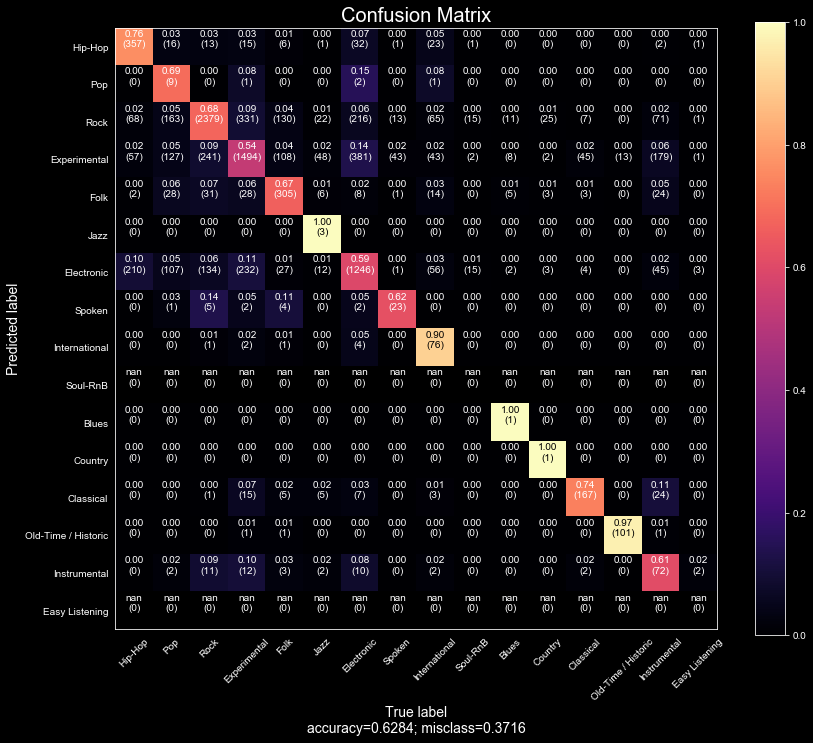

In [27]:
def plot_confusion_matrix(cm2, target_names, title='Confusion Matrix', cmap=None, normalize=True):

    accuracy = np.trace(cm2) / float(np.sum(cm2))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 10))
    plt.title(title, fontsize=20)
    

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm1 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
        plt.imshow(cm1, interpolation='nearest', cmap=cmap)
        plt.clim(0, 1)
    else:
        plt.imshow(cm2, interpolation='nearest', cmap=cmap)

    thresh = cm1.max() / 1.5 if normalize else cm1.max() / 2
    for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}\n({})".format(cm1[i, j], cm2[i,j]),
                     horizontalalignment="center",
                     color="black" if cm1[i, j] > 0.8 else "white")
        else:
            plt.text(j, i, "{:,}".format(cm2[i, j]),
                     horizontalalignment="center",
                     color="black" if cm2[i, j] > 1240 else "white")

    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('Predicted label', fontsize=14)
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=14)
    plt.show()

plot_confusion_matrix(rfc_conf_matrix, target_names = with_genres['genre_top'].unique(), 
                      cmap='magma', normalize=True);
# Here we can visualize the large amount of errors, but we also see the genres with few observations
# like Pop, Jazz, International, see to do well in general, and genres with more observations are not
# doing as well. One factor may be Rock, Experimental and Electronic may have lots of genre crossover
# that may be hard to distinguish.

## 4. Model Creation

In [28]:
# Setting up the model with just the high import cols to see if increases performance...
X = with_genres[high_import_cols]
Y = with_genres['factorized_genres']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=79)

# Running random forest classifier
classifier = RandomForestClassifier(n_estimators=50, criterion='entropy')
classifier.fit(X_train,Y_train)

classifier.score(X_test, Y_test)
# Not much improvement here

0.6244959677419355

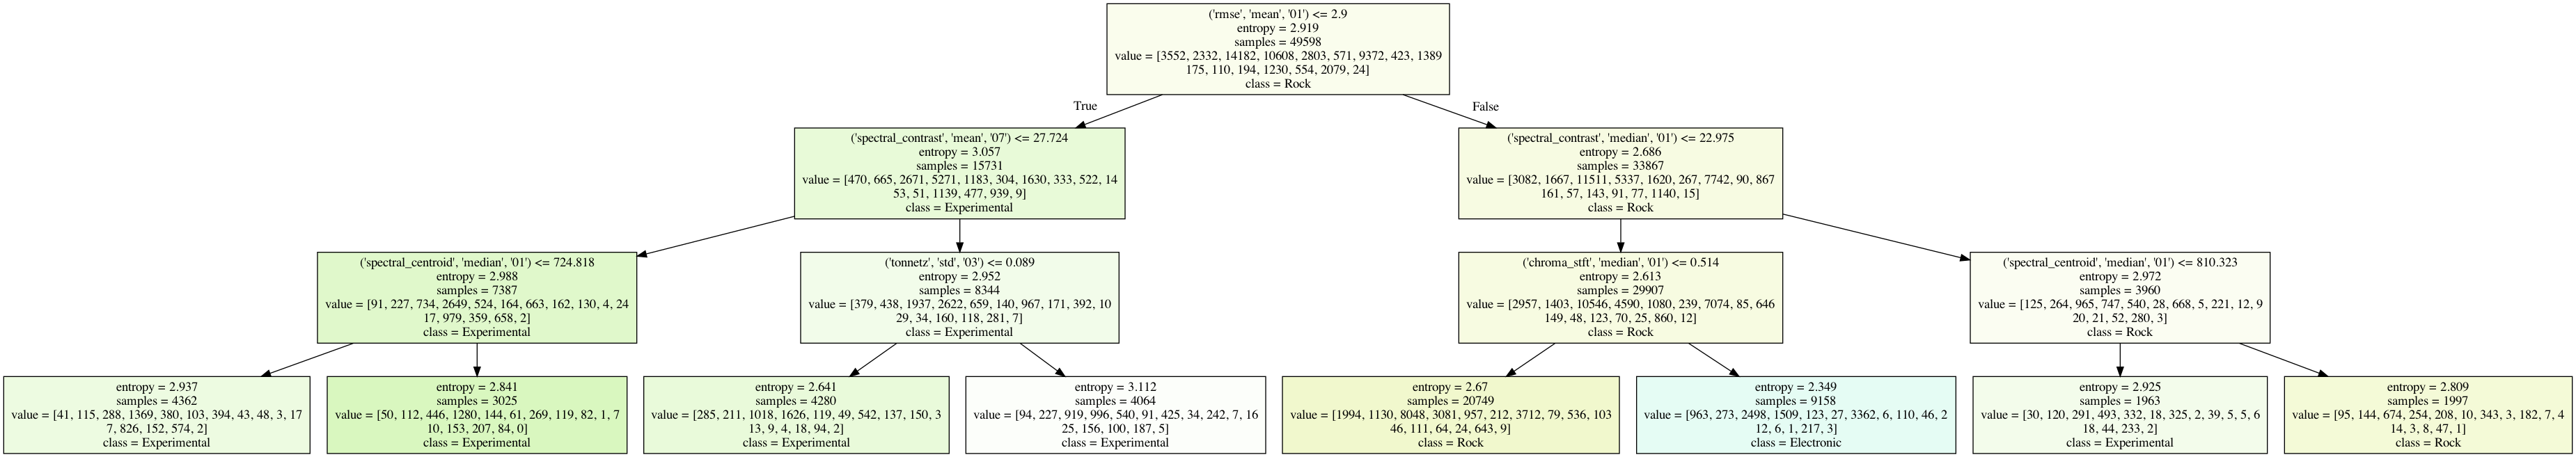

In [29]:
# Let's use a decision tree to see how the RFC is making predictions
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=3
)

decision_tree.fit(X,Y)

dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=list(with_genres.genre_top.unique()),
    filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())
# We can see the abundance of Rock, Experimental, and Electronic genres dominate the predictors

In [30]:
# Due to the amount of errors in the previous model, let's
# set up a model where X is just rock music with OvA encoding
with_genres['rock_encode'] = with_genres['genre_top'].apply(lambda x: 1 if x == 'Rock' else 0)

In [31]:
with_genres[['genre_top', 'rock_encode']]

,genre_top,rock_encode
track_id,,
2,Hip-Hop,0
3,Hip-Hop,0
5,Hip-Hop,0
10,Pop,0
134,Hip-Hop,0
...,...,...
155315,Rock,1
155316,Rock,1
155317,Rock,1


In [32]:
# Setting up the model with just the high import cols and the target as just Rock
X = with_genres[high_import_cols]
Y = with_genres['rock_encode']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=79)

# Running random forest classifier
rfclassifier = RandomForestClassifier(n_estimators=75, criterion='entropy')
rfclassifier.fit(X_train,Y_train)

rfclassifier.score(X_test, Y_test)
# Serious improvement on previous model

0.8794354838709677

In [33]:
# Predictions
Y_pred = rfclassifier.predict(X_test)

rfc_conf_matrix = confusion_matrix(Y_pred, Y_test)

In [ ]:
def plot_confusion_matrix(cm2,target_names,title='Confusion Matrix',cmap=None,normalize=True):
    plt.figure(figsize=(8, 6))
    
    accuracy = np.trace(cm2) / float(np.sum(cm2))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')    

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm1 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
        plt.imshow(cm1, interpolation='nearest', cmap=cmap)
        plt.clim(0, 1)

    thresh = cm1.max() / 1.5 if normalize else cm1.max() / 2
    for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}\n({})".format(cm1[i, j], cm2[i,j]),
                    horizontalalignment="center",
                    color="black"),
    
    
        else:
            plt.text(j, i, "{:,}".format(cm2[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
                    
    plt.title(title, fontsize=20)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('Predicted label', fontsize=14)
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=14)
    plt.show()

plot_confusion_matrix(rfc_conf_matrix, target_names = ['Rock', 'Other'], 
                      cmap='BuPu', normalize=True)

In [ ]:
song = with_genres.iloc[3967, :-3]
song

In [50]:
# Let's go back to our song selection and see what this model predicts the song to be:
rfclassifier.predict_proba(with_genres.iloc[9555, :-3])

ValueError: Expected 2D array, got 1D array instead:
array=[ 1.09306836e+00  1.12626636e+00  9.19944227e-01  8.78630400e-01
  1.32540762e+00  1.27736175e+00  9.70946789e-01  1.54463127e-01
  1.96224138e-01  2.97549009e-01  4.50235486e-01  7.33028054e-01
  6.51316524e-01  6.20684922e-01  6.39256597e-01  5.88405311e-01
  6.15259707e-01  4.65472817e-01  4.86421078e-01  5.41527033e-01
  6.34193480e-01  6.29355431e-01  6.44829810e-01  6.33946180e-01
  2.94794381e-01  2.63783514e-01  2.55199462e-01  2.60001749e-01
  2.54012406e-01  2.54079789e-01  2.57485569e-01  2.91586667e-01
  3.04400772e-01  2.95378506e-01  2.97686577e-01  2.74416536e-01
  2.81951308e-01  2.55765140e-01  2.55903929e-01  2.60391176e-01
  2.55454838e-01  2.54601568e-01  2.54920691e-01  2.89760381e-01
  3.04181993e-01  2.82379091e-01  2.74244547e-01  2.50208080e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.27526641e-01  4.35827792e-01 -2.27029733e-02 -5.75399399e-02
 -2.79913276e-01 -3.50150853e-01 -8.25186223e-02 -9.98045206e-02
 -5.73372878e-02  3.19428116e-01  6.14783585e-01  8.65331173e-01
  8.96347687e-02  8.38637054e-02  7.66833052e-02  7.52218068e-02
  6.81363717e-02  6.35904521e-02  6.52211085e-02  8.32898244e-02
  8.68220478e-02  9.14096609e-02  1.03144646e-01  1.00796647e-01
 -9.94782984e-01 -1.03103542e+00 -1.04653859e+00 -1.03829658e+00
 -9.96220827e-01 -9.82881904e-01 -9.69092727e-01 -1.08489764e+00
 -8.95934105e-01 -7.71014452e-01 -7.92995274e-01 -7.41852283e-01
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  6.25593007e-01  5.86180806e-01  5.77972174e-01  5.84395885e-01
  5.74393809e-01  5.69468737e-01  5.71944535e-01  6.29844964e-01
  6.47671878e-01  6.21984959e-01  6.18291497e-01  5.78411937e-01
  6.35650754e-01  5.95960498e-01  5.93217671e-01  6.00426435e-01
  5.84679008e-01  5.73152602e-01  5.77677071e-01  6.52300239e-01
  6.74564183e-01  6.24532521e-01  6.11714959e-01  5.63942552e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.57078147e-01 -7.50614405e-02 -8.74974728e-02 -1.11858971e-01
 -7.76767209e-02 -2.14136876e-02 -3.34837288e-02 -2.33317718e-01
 -3.54590744e-01 -1.62664205e-01 -5.82813770e-02  1.24114498e-01
  2.52834380e-01  2.56320238e-01  2.58433580e-01  2.60934383e-01
  2.55187929e-01  2.51132637e-01  2.48650223e-01  2.69143939e-01
  2.60361731e-01  2.43771404e-01  2.40021586e-01  2.35058859e-01
 -1.26202035e+00 -1.16730893e+00 -1.14537120e+00 -1.24203312e+00
 -1.26672637e+00 -1.14570081e+00 -1.12955487e+00 -1.19851530e+00
 -1.15835214e+00 -1.26028371e+00 -1.37490749e+00 -1.38195622e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  4.57119018e-01  4.16394800e-01  4.15344268e-01  4.41985905e-01
  4.55477953e-01  4.49729770e-01  4.51511830e-01  4.75210428e-01
  4.91222918e-01  5.17333150e-01  5.54230928e-01  5.25203884e-01
  4.09721315e-01  3.58670741e-01  3.72680187e-01  4.03086931e-01
  4.35533822e-01  4.17474836e-01  4.29255366e-01  4.51017797e-01
  4.85109597e-01  5.05003512e-01  5.65286934e-01  5.28953493e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.13528538e-01  3.97924513e-01  3.59838396e-01  2.92067826e-01
  2.04142213e-01  3.01047027e-01  2.56514370e-01  2.18240872e-01
  1.10075451e-01  9.16719213e-02 -7.04600960e-02  1.79038532e-02
  3.24244589e-01  3.14456522e-01  3.11495125e-01  3.27872843e-01
  3.22302729e-01  3.14933807e-01  3.02500874e-01  3.16282451e-01
  3.01760495e-01  3.15110683e-01  3.25963318e-01  3.24592888e-01
 -4.99043614e-01  3.05734873e-01 -9.73808408e-01  3.76545973e-02
  4.44194704e-01 -6.47706330e-01 -4.26278949e-01 -5.18659770e-01
 -4.75229442e-01 -3.98150146e-01  9.90440696e-02  2.06386775e-01
  1.42470345e-01  4.18351263e-01  2.86762953e-01 -2.51305193e-01
  3.40417892e-01  3.80021363e-01  6.13938048e-02  3.07078242e-01
 -1.10483198e+01  2.70089752e+02  7.20928955e+01  1.07977654e+02
  5.91304970e+01  5.30631294e+01  6.38911743e+01  4.09232903e+01
  3.86351471e+01  4.08131714e+01  3.77102051e+01  3.70057449e+01
  3.21561699e+01  3.04296570e+01  2.78731651e+01  2.57271366e+01
  2.87030697e+01  2.81517200e+01  1.88944225e+01  2.39362431e+01
 -2.61740570e+02  1.64328079e+02 -2.44318428e+01  2.88312874e+01
  9.40633965e+00 -9.79631329e+00  1.07072296e+01  3.10334468e+00
  4.07236308e-01  5.34149647e+00 -2.39452529e+00 -6.54539168e-01
  1.89761972e+00 -1.63841093e+00 -7.52692461e-01 -6.15088105e-01
  1.17671728e+00  8.47646832e-01 -3.12053752e+00 -2.09204555e-01
 -2.49461853e+02  1.60658569e+02 -2.51744537e+01  2.62417107e+01
  1.16342096e+01 -9.53022194e+00  1.18563786e+01  3.53497910e+00
  8.98508012e-01  5.85078764e+00 -2.12985420e+00 -8.13811064e-01
  1.91756248e+00 -2.23831201e+00 -1.02266228e+00 -2.05060199e-01
  1.32561481e+00  1.08140373e+00 -2.59371972e+00 -2.64565110e-01
 -5.37228882e+02 -5.68434189e-14 -1.43934433e+02 -4.87792816e+01
 -5.78007126e+01 -5.01089096e+01 -4.12403526e+01 -3.81848602e+01
 -3.82178421e+01 -3.88602791e+01 -3.45332222e+01 -3.23275871e+01
 -2.83285408e+01 -3.03445053e+01 -2.85949593e+01 -2.74563351e+01
 -2.62079067e+01 -2.39270401e+01 -2.87358246e+01 -2.40651169e+01
 -2.79973745e-01 -2.72213370e-01 -1.72310740e-01  2.44467095e-01
 -5.77289820e-01  1.34826871e-02 -1.88537121e-01 -9.13881212e-02
 -1.96569830e-01 -1.66113719e-01 -4.19115573e-02  1.65169597e-01
  6.11144826e-02  3.75020236e-01  2.06629962e-01 -8.88406485e-02
 -8.20469260e-02 -1.73512965e-01 -3.05254251e-01  1.46926835e-01
  8.29652939e+01  4.15095749e+01  3.99792366e+01  2.45431747e+01
  1.68261204e+01  1.47787828e+01  1.37343721e+01  1.15677376e+01
  1.04678955e+01  1.03401127e+01  8.43526077e+00  8.08587646e+00
  7.46146441e+00  7.67235899e+00  6.88637114e+00  7.00862694e+00
  6.34023666e+00  6.15566587e+00  6.05968666e+00  5.63434267e+00
  1.84343815e-01  1.10806704e+01  2.18992996e+00  1.67793953e+00
  0.00000000e+00  9.01924133e-01  1.77674186e+00  3.71865416e+00
  3.51415015e+03  1.11894958e+03  1.07965942e+03  0.00000000e+00
  1.01938546e+00  3.56628204e+02  4.81643295e+00  5.58038672e+03
  9.69114075e+02  8.40842896e+02  0.00000000e+00  1.66899252e+00
  4.88939575e+02  1.80613518e+00  2.02393070e-01  1.45085847e+00
  8.98477614e-01  1.12205230e-01  4.15677643e+00  1.36879606e+01
  5.53782463e+01  4.13470154e+01  4.89298019e+01  3.26168938e+01
  3.42944946e+01  3.20871048e+01  4.83709183e+01  1.62583313e+01
  1.40195084e+01  1.49751654e+01  1.48442163e+01  1.70601139e+01
  1.97712860e+01  2.91500645e+01  1.54706850e+01  1.33825798e+01
  1.44483547e+01  1.45596781e+01  1.70090714e+01  1.97728786e+01
  2.86146297e+01  1.72549343e+00  2.14983511e+00  2.22195148e+00
  1.87515140e+00  2.32609749e+00  1.53833055e+00  9.94728851e+00
  9.76159751e-01  6.14892423e-01  8.42568040e-01  5.81568837e-01
  7.20461830e-02 -1.13101137e+00 -4.92914915e-02  5.23363256e+00
  4.78394222e+00  3.97897601e+00  2.92390275e+00  3.06456470e+00
  3.43782783e+00  2.94292903e+00  5.64898348e+00  9.64687500e+03
  1.83639197e+03  1.76572266e+03  0.00000000e+00  1.36328328e+00
  9.20933655e+02  2.21750879e+00  5.79006910e-01  8.98547292e-01
  1.05560160e+00  1.45902053e-01  7.84969854e+00  6.46467060e-02
  1.26020744e-01  2.11263880e-01  2.30901286e-01  4.97031510e-02
  1.28848940e-01 -6.32549496e-03  1.23497071e-02  3.98040283e-03
  1.28406063e-02  2.48993118e-03  1.52346073e-03 -6.33611809e-03
  1.16277011e-02  3.58041772e-03  1.31029747e-02  2.42972677e-03
  1.40534504e-03 -1.37703747e-01 -5.75206056e-02 -1.81557208e-01
 -2.21896276e-01 -4.44101095e-02 -5.17410748e-02 -4.15499598e-01
  3.19249868e-01  1.22650899e-01 -6.37144595e-02 -2.94543300e-02
  1.09960234e+00  2.12021247e-02  2.13409420e-02  4.94684391e-02
  5.00413850e-02  1.34517793e-02  1.53656602e-02  4.73889112e+00
  2.65136719e-01  4.84241992e-02  3.17382812e-02  0.00000000e+00
  2.23389339e+00  4.72995602e-02  2.57000000e+02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

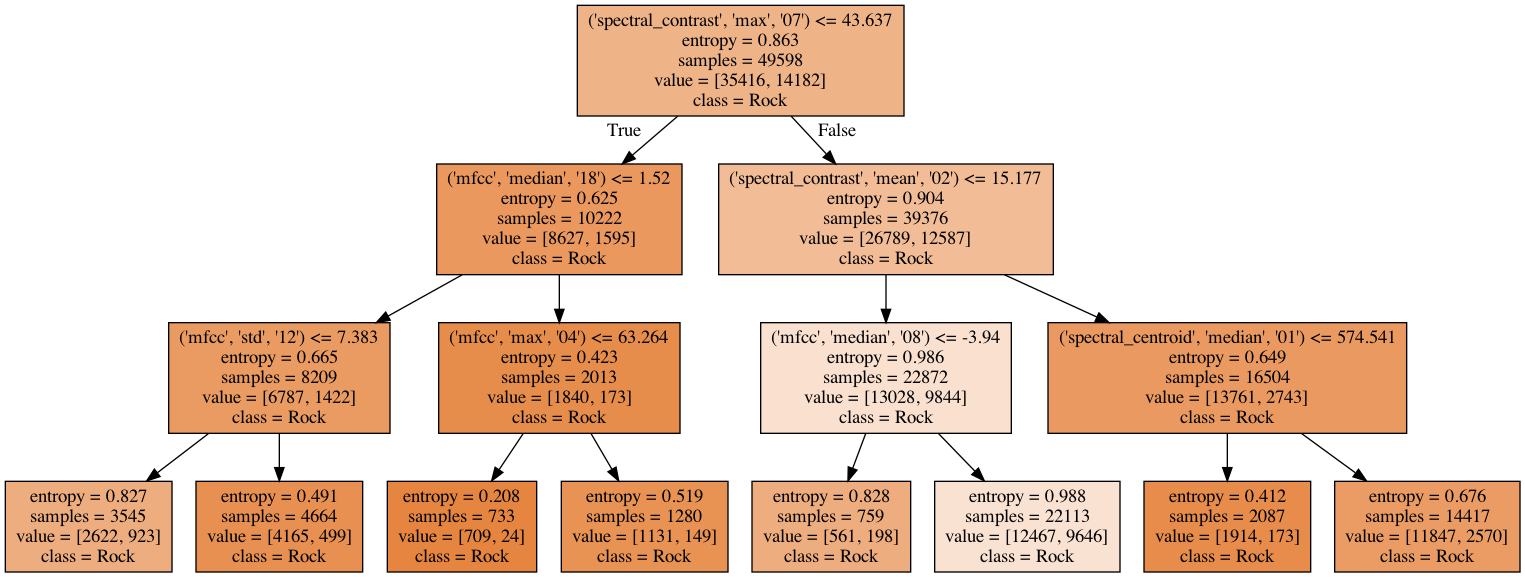

In [68]:
# Looking at the choices for the RFC by looking at a Decision Tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=3
)

decision_tree.fit(X,Y)

dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Rock', 'Other'],
    filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [69]:
# While the RFC made a major improvement, let's try running a different model to guage performance
import xgboost as xgb
model=xgb.XGBClassifier(learning_rate=0.01)
model.fit(X_train, Y_train)
model.score(X_test,Y_test)

# RFC Seems to perform better. Let's try another model.

0.8574596774193548

In [ ]:
# get a stacking ensemble of models
# Run on Rock v Other target
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('bayes', GaussianNB()))
    
    # define meta learner model
    level1 = LogisticRegression()
    
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()
    return models

# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    

#>lr 0.834 (0.005)
#>knn 0.803 (0.004)
#>cart 0.789 (0.005)
#>bayes 0.751 (0.006)
#>stacking 0.850 (0.004)

# Stacking does the best of the 5, but still not as good as RFC

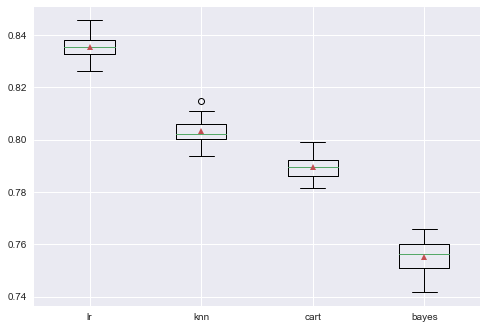

In [71]:
plt.style.use('seaborn')
plt.boxplot(results, labels=names, showmeans=True);

In [73]:
# Since we had success singling out Rock, let's do the reverse and remove the most represented
# genres and see if we get better results for the underrepresented genres

underrep_genres = with_genres.copy()
upderrep_genres = underrep_genres.drop(['factorized_genres'], axis=1, inplace=True)
underrep_genres = underrep_genres[(underrep_genres['genre_top'] != 'Rock') & 
                                    (underrep_genres['genre_top'] != 'Experimental') &
                                    (underrep_genres['genre_top'] != 'Electronic')]

In [74]:
# Verifying genres removed 
underrep_genres.genre_top.unique()

array(['Hip-Hop', 'Pop', 'Folk', 'Jazz', 'Spoken', 'International',
       'Soul-RnB', 'Blues', 'Country', 'Classical', 'Old-Time / Historic',
       'Instrumental', 'Easy Listening'], dtype=object)

In [75]:
# Factorizing the remaining genres
factorize2 = pd.factorize(underrep_genres.genre_top)
underrep_genres['factorized'] = factorize2[0]
definitions2 = factorize2[1]

In [78]:
# Setting up the new model
X = underrep_genres.iloc[:,:-3]
Y = underrep_genres['factorized']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=79)

# Running random forest classifier
rfclassifier = RandomForestClassifier(n_estimators=75, criterion='entropy')
rfclassifier.fit(X_train,Y_train)

scores = cross_val_score(rfclassifier, X_train, Y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(np.mean(scores))
# The score here is likely due to not having enough samples per genre
# We might be able to improve this score through attaining more data in librosa, but
# that is for a future project

0.629252643713218
